# **Working Process**
1. 데이터 수집하기
1. 수집데이터 전처리 NDBMS
1. Token 의 정리 (wordCloud)
1. N-Gram 의 정리 (메뉴명 PMI)
1. Clustering (군집화 묶기)
1. Token 간 관계 분석하기
1. 데이터 정리 및 모델링

# **Data from Muyong**
! pip install xlrd
## **1 sheet Names**
엑셀내 시트내용 살펴보기

In [3]:
import xlrd, re
xls_file = r'backup/menuData_muyong.xlsx'
xls = xlrd.open_workbook(xls_file, on_demand=True)
sheetName = xls.sheet_names()
print(sheetName[:5])

from tqdm import tqdm
shtList = []
for _ in tqdm(sheetName):
    chk = re.findall(r"(\d+).(\d+)[-.](\d+)",_)
    if chk:
        if len("".join(chk[0])) < 5: print(_)
        else: shtList.append(_)
    else: print(_)
        
len(shtList)

100%|██████████| 253/253 [00:00<00:00, 269193.03it/s]

['업체별단가 및 사모님이 사오시는 품목', '사용량', '18년1.16-24', '18년2.20-', '18.03.20']
업체별단가 및 사모님이 사오시는 품목
사용량


251

In [4]:
# merge cell 때문에 전체가 보이질 않는다 ㅠㅠ..
import pandas as pd
pd.read_excel(xls_file, sheetName=shtList[5]).head(2)

,품명,신용축산,비앤피,사모님이 사오시는품목
0,NaN,031 426 8833,010 3805 4938,NaN
1,목전지(제육),4800,4700,굴소스


## **2 lambda 수식의 활용**
큰 데이터를 처리시, for 문에 비해 훨씬 효과가 빠르다
1. https://dojang.io/mod/page/view.php?id=1059
1. http://book.pythontips.com/en/latest/lambdas.html
1. https://stackoverflow.com/questions/31206106/compare-each-item-of-two-lists-in-python

In [1]:
# lambda 를 활용한 계산
add = lambda x, y: x + y
add(3, 5)

8

In [2]:
# lambda 를 활용한 정렬
a = [(1, 2), (4, 1), (9, 10), (13, -3)]
a.sort(key=lambda x: x[1])
a

[(13, -3), (4, 1), (1, 2), (9, 10)]

In [3]:
list1, list2 = (1,2,3,4,5), (10,20,30,40,50)
data = zip(list1, list2)
# data.sort()  # .sort는 오류를 발생한다
# data
list1, list2 = map(lambda t: list(t), zip(*data))
print("list1 : {}\nlist2 : {}".format(list1, list2))

list1 : [1, 2, 3, 4, 5]
list2 : [10, 20, 30, 40, 50]


In [4]:
# itertools 을 활용
import itertools
list_1 = [1,5,4]
list_2 = [2,3,4]
# using list comprehensions
comparisons = [a == b for (a, b) in itertools.product(list_1, list_2)]
sums        = [a + b  for (a, b) in itertools.product(list_1, list_2)]
print("값 비교 : {}\n값의 합 : {}".format(comparisons,sums))

값 비교 : [False, False, False, False, False, False, False, False, True]
값의 합 : [3, 4, 5, 7, 8, 9, 6, 7, 8]


In [5]:
lst1 = [1,5,4]
lst2 = [2,3,4]
lst3 = list(map(lambda x: x[0] == x[1] , itertools.product(lst1,lst2)))
print('lst3 Row data : {}\nCounting "True" data : {}'.format(lst3, sum(lst3)))

lst3 Row data : [False, False, False, False, False, False, False, False, True]
Counting "True" data : 1


# **Process Goal**
- 여러가지 작업방법을 사용하여 원하는 사전을 구축하는 것!!!
- 결국은 **사전을 구축하며 내용을 확인 가능해야 Huristic 개념에서 Algorithm 으로** 넘어갈 수 있다
- 음식과 메뉴 관련된 단어들만 추출가능하도록 모듈 구성하기
- Token 들 중 음식과 관련된 단어들만 찾기
- 유효한 값 2000개 중 음식과 관련 없는 것들만 제거하기

## **1 NLP 전처리**
문장과 단어의 유사도 및 성격 분석및 측정하기

In [1]:
text1 = "자연 언어에 대한 연구는 오래전부터 이어져 오고 있음에도 2018년까지도 사람처럼 이해하지는 못한다.".split()
text2 = "자연 언어에 대한 연구는 오래전부터 이어져 들어서도 아직 컴퓨터가 사람처럼 이해하지는 못한다.".split()
text3 = "자연 아직 컴퓨터가 언어에 들어서도 못한다 이어져 사람처럼 이해하지는 대한 연구는 오래전부터.".split()
len(text1), len(text2), len(text3)

(12, 12, 12)

In [2]:
from nltk.metrics import edit_distance
print(edit_distance('파이썬 알고리즘', '파파미 알탕'))

print('생략된 단어가 다를 때 : {} \n어휘 순서를 바꿨을 때 : {}'.format(
    edit_distance(text1, text2), 
    edit_distance(text2, text3)))

5
생략된 단어가 다를 때 : 3 
어휘 순서를 바꿨을 때 : 10


In [3]:
# 02 accuracy 정확도 측정
from nltk.metrics import accuracy
accuracy('파이썬', '파이프')

0.6666666666666666

In [5]:
print('생략된 단어가 다를 때 {:.4} \n어휘 순서를 바꿨을 때 {:.4}'.format(
    accuracy(text1, text2), 
    accuracy(text2, text3)))

생략된 단어가 다를 때 0.75 
어휘 순서를 바꿨을 때 0.08333


In [6]:
text1 = set(text1)
text2 = set(text2)
text3 = set(text3)
print(len(text1), len(text2), len(text3))
from nltk.metrics import precision
precision({'파이썬'}, {'파르썬'})

12 12 12


0.0

In [7]:
print('생략된 단어가 다를 때 {:.4} \n어휘 순서를 바꿨을 때 {:.4}'.format(
    precision(set(text1), set(text2)), 
    precision(set(text2), set(text3))))

생략된 단어가 다를 때 0.75 
어휘 순서를 바꿨을 때 0.8333


In [8]:
from nltk.metrics import recall
print('생략된 단어가 다를 때 {:.4} \n어휘 순서를 바꿨을 때 {:.4}'.format(
    recall(text1, text2), 
    recall(text2, text3)))

생략된 단어가 다를 때 0.75 
어휘 순서를 바꿨을 때 0.8333


## **1 데이터 불러오기**
음식데이터는 Mecab() 보다 Okt() 가 더 효과적인 단어목록을 포함
1. 제목 단어들을 묶어서 **word Piece Model** 로 **유효단어** 추출하기
1. 유사한 그룹은 편집거리를 활용하여 묶기

In [9]:
import pandas as pd
df = pd.read_csv('data/1000recipe.csv', sep="|")
df = df.fillna("") # NaN 데이터 전처리를 해야 다음 과정들이 진행
titles = df.Menu.tolist()
titles = " ".join(titles)

# with open('menuTitles.txt', 'w') as f:
#     f.write(menuTitle)
titles[:200]

'호불호 없는 토마토파스타는 역시 ~! 토마토냉파스타 ★ 달콤 촉촉 달걀 푸딩 만들기, 만드는 법 ( 부드러운 달걀 요리 기본 원리 ) 손이가요 손이가~~자꾸 손이 가는 [가지전] 여름 무로 깔끔아삭 무채무침 흰 강낭콩 바나나 쉐이크 다이어트&아침 대용 깻잎절임 : 입맛 되살리는 초간단 반찬 소고기 장조림 만들기 간단반찬 으로 최고! 차돌박이 부추무침, 간단'

In [10]:
import re
titles = re.findall(r"[가-힣]+", titles)
titles = " ".join(titles).lower()
titles_raw = titles.split(" ")

from collections import Counter
Counter(titles_raw).most_common(10)

[('만들기', 17314),
 ('만드는', 5224),
 ('법', 3834),
 ('회', 3741),
 ('초간단', 3565),
 ('레시피', 3394),
 ('만드는법', 2753),
 ('맛있는', 2655),
 ('좋은', 2387),
 ('맛있게', 2212)]

## **2 Nltk 객체를 활용한 가치있는 단어들 추출**
```python
# nltk 에서 분석가능한 객체를 자동으로 생성
# 식품메뉴명에는 Okt() 가 사전이 더 좋음
titles = Okt().pos(titles, stem=True)
```

In [11]:
%%time
from nltk import Text
from konlpy.tag import Mecab, Okt
titles_noun = Okt().nouns(titles)
title_obj   = Text(titles_noun)

# .B() : Unique 한 Token 갯수
# .N() : 전체 Token 의 갯수
title_obj.vocab().N(),  title_obj.vocab().B(),  int(title_obj.vocab().N()/title_obj.vocab().B())

CPU times: user 1min 57s, sys: 477 ms, total: 1min 58s
Wall time: 1min 26s


(569021, 13467, 42)

In [12]:
from nltk import collocations
finder   = collocations.BigramCollocationFinder.from_words(titles_noun)
measures = collocations.BigramAssocMeasures()
finder.nbest(measures.pmi, 10)

[('가까이', '쑥굴국'),
 ('감탄사', '연발'),
 ('갑농', '산이'),
 ('개두', '릎'),
 ('갯벌', '환경'),
 ('거성', '그룹'),
 ('검', '은빛'),
 ('검사', '외조'),
 ('검은색', '수상한'),
 ('결명자', '불우')]

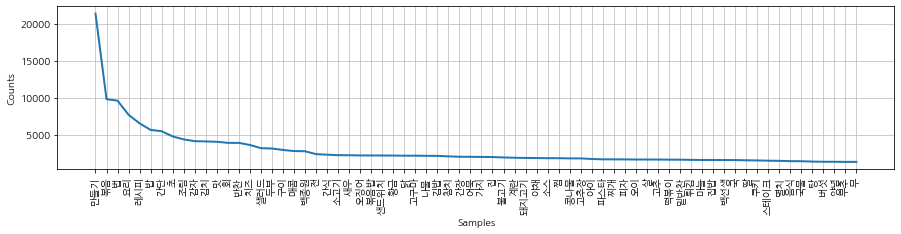

In [13]:
%matplotlib inline
from matplotlib import rc, rcParams
rc('font', family=['NanumGothic','Malgun Gothic']) # 한글의 표시
rcParams['axes.unicode_minus'] = False             # '-' 표시의 처리

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 3))  # 파레트 설정
title_obj.plot(70)

In [14]:
maxLimits = 1950
title_obj.vocab().most_common(maxLimits)[(maxLimits-10):]

[('월병', 26),
 ('벨기에', 26),
 ('뒷다리', 26),
 ('웰치', 26),
 ('필라프', 25),
 ('술빵', 25),
 ('여기', 25),
 ('콩물', 25),
 ('청양', 25),
 ('널', 25)]

In [15]:
" ".join([_[0] for _ in title_obj.vocab().most_common(100)])

'만들기 볶음 법 요리 레시피 밥 간단 초 조림 감자 김치 맛 회 반찬 치즈 샐러드 두부 구이 매콤 백종원 전 간식 소고기 새우 오징어 볶음밥 샌드위치 황금 닭 고구마 나물 김밥 참치 간장 어묵 가지 집 불고기 계란 돼지고기 야채 소스 찜 콩나물 고추장 아이 파스타 찌개 피자 오이 살 고추 떡볶이 밑반찬 튀김 마늘 집밥 백선생 국 딸 쿠키 스테이크 멸치 음식 국물 탕 버섯 양념 부추 무 크림 치킨 토마토 떡 만두 토스트 잡채 향 냉장고 달걀 버터 카레 삼겹살 가슴 오븐 라면 말 장조림 베이컨 된장 도시락 영양 빵 그릇 케이크 식빵 방법 봄 여름 알'

## **3 N Gram 을 활용한 PMI 분석**
nltk tools
1. **음식 이외의 정보들도 포함** 되어 있어서 **결과해석이 용이하지 못함**
1. **음식을 직접 언급한 문장** 만으로 **분석하는 등의** 별도 과정이 필요

In [20]:
from nltk import collocations
finder   = collocations.BigramCollocationFinder.from_words(titles_raw)
measures = collocations.BigramAssocMeasures()
finder.nbest(measures.pmi, 4)

[('가까이', '왔네요'), ('가끔씩은', '초식도'), ('가나슈로', '아이싱한'), ('가나슈마카롱', '씨앗이')]

In [21]:
finder = collocations.BigramCollocationFinder.from_words(titles_noun)
measures = collocations.BigramAssocMeasures()
finder.nbest(measures.pmi, 4)

[('가까이', '쑥굴국'), ('감탄사', '연발'), ('갑농', '산이'), ('개두', '릎')]

In [22]:
finder   = collocations.TrigramCollocationFinder.from_words(titles_raw)
measures = collocations.TrigramAssocMeasures()
finder.nbest(measures.pmi, 4)

[('가까이', '왔네요', '쑥굴국'),
 ('가스레인지추천', '국내최초', '라면자동요리'),
 ('가스불이', '안켜져', '난감한데'),
 ('가슴속에', '차오르는', '연')]

In [23]:
finder   = collocations.TrigramCollocationFinder.from_words(titles_noun)
measures = collocations.TrigramAssocMeasures()
finder.nbest(measures.pmi, 4)

[('갯벌', '환경', '지표'),
 ('거성', '그룹', '구일'),
 ('계정', '바오지', '딩'),
 ('궁보', '계정', '바오지')]